In [64]:
# A sanity check for the implementation of MADE.
import optax
from jaxrl.networks.policies import NormalTanhMixturePolicy
from jaxrl.networks.autoregressive_policy import MADETanhMixturePolicy
import matplotlib.pyplot as plt
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib
%matplotlib inline

In [65]:
@jax.jit
def sample(rng, inputs, std=0.1):
    num_points = len(inputs)
    rng, key = jax.random.split(rng)
    n = jnp.sqrt(jax.random.uniform(key, shape=(num_points // 2,))
                 ) * 540 * (2 * np.pi) / 360
    rng, key = jax.random.split(rng)
    d1x = -jnp.cos(n) * n + jax.random.uniform(key,
                                               shape=(num_points // 2,)) * 0.5
    rng, key = jax.random.split(rng)
    d1y = jnp.sin(n) * n + jax.random.uniform(key,
                                              shape=(num_points // 2,)) * 0.5
    x = jnp.concatenate(
        [
            jnp.stack([d1x, d1y], axis=-1),
            jnp.stack([-d1x, -d1y], axis=-1)
        ]
    )

    rng, key = jax.random.split(rng)
    x = x / 3 + jax.random.normal(key, x.shape) * std
    return jnp.clip(x / 5 + inputs, -0.9999, 0.9999)


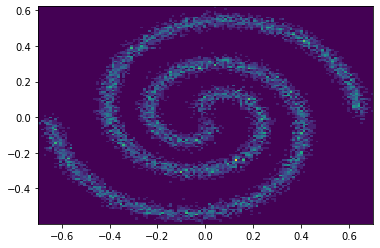

In [66]:
tmp = sample(jax.random.PRNGKey(1), jnp.zeros((10024, 2)))
x = plt.hist2d(tmp[:, 0], tmp[:, 1], bins=128)


In [67]:
rng = jax.random.PRNGKey(1)
made = NormalTanhMixturePolicy((128, 128), 2)  # Fails
made = MADETanhMixturePolicy((128, 128), 2)  # Works
rng, key = jax.random.split(rng)
params = made.init(key, jnp.zeros(2))['params']

optim = optax.adamw(3e-4)
optim_state = optim.init(params)


In [68]:
@jax.jit
def train_step(rng, params, optim_state):
    rng, key1, key2 = jax.random.split(rng, 3)
    xs = jax.random.normal(key1, shape=(1024, 2)) * 0.1
    ys = sample(key2, xs)

    def loss_fn(params):
        dist = made.apply_fn({'params': params}, xs)
        log_probs = dist.log_prob(ys)
        return -log_probs.mean()

    loss_fn(params)
    value, grads = jax.value_and_grad(loss_fn)(params)

    updates, new_optim_state = optim.update(grads, optim_state, params)
    new_params = optax.apply_updates(params, updates)

    return value, rng, new_params, new_optim_state


In [69]:
for i in range(100000):
    value, rng, params, optim_state = train_step(rng, params, optim_state)
    if i % 10000 == 0:
        print(value)


2.6660337
-0.5110734
-0.48464105


In [ ]:
@jax.jit
def get_log_probs(xs, ys, params):
    dist = made.apply_fn({'params': params}, xs)
    return dist.log_prob(ys)


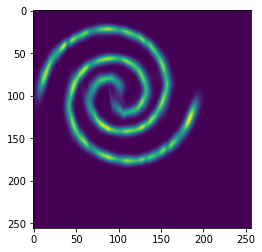

In [ ]:
x = jnp.linspace(-0.9, 0.9, 256)
y = jnp.linspace(-0.9, 0.9, 256)
xv, yv = jnp.meshgrid(x, y)

ys = jnp.stack([xv, yv], -1)
xs = jnp.zeros_like(ys) - 0.2

log_probs = get_log_probs(xs, ys, params)

plt.imshow(jnp.exp(log_probs))
